# Cosmology project: Measuring Cosmic acceleration with Type Ia Supernovaes

Authors: Oriol Abril Pla, Mariona Badenas Agusti

April 2018

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import pandas as pd
import matplotlib.pyplot as plt

import scipy.optimize as opt
import scipy.integrate as pyint
import scipy.constants as const
import scipy.stats as stat
import numpy as np

from matplotlib import rcParams
rcParams['figure.figsize'] = 5.5, 3.2
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

#### Load the data
Load the sample from Union2 SNe and select only the desired coordinates.

In [2]:
database_file = 'SCPUnion2.1_AllSNe.txt'
SNe_df = pd.read_csv(database_file,header=None, sep=r'\)?\s+&\s+', engine='python', na_filter = ['\nodata','\nodata\\'],
                    names=['ID', 'z', 'Mb',  'stretch', 'color',
                           'd_mod', 'unknown', 'sample', 'Cuts Failed']).set_index('ID')
SNe_df['Cuts Failed'] = SNe_df['Cuts Failed'].str.slice(stop=-2)

In [3]:
def split_errors(df,name):
    #print df.loc[df[name]==na][name]
    mask = df[name].str.slice(start=-6)=='nodata'
    df.loc[mask, name] = 'NaN(NaN'
    split_df = df[name].str.split('(',expand=True)
    df[name] = split_df[0].astype(float)
    df['err_{}'.format(name)] = split_df[1].astype(float)
split_errors(SNe_df,'Mb')
split_errors(SNe_df,'stretch')
split_errors(SNe_df,'color')
split_errors(SNe_df,'d_mod')
nice_columns = ['z', 'Mb', 'err_Mb',  'color', 'err_color',
                           'd_mod', 'err_d_mod']
SNe_df = SNe_df[nice_columns]
SNe_df.head()

,z,Mb,err_Mb,color,err_color,d_mod,err_d_mod
ID,,,,,,,
1993ah,0.0285,16.86,0.19,0.23,0.09,35.35,0.22
1993ag,0.0500,17.79,0.05,0.12,0.02,36.68,0.17
1993o,0.0529,17.60,0.05,-0.01,0.02,36.82,0.16
1993b,0.0701,18.43,0.04,0.09,0.02,37.45,0.16
1992bs,0.0627,18.25,0.05,0.02,0.02,37.48,0.16


## Find cosmological parameters 
### Flat universe and w=0
[2018-04-05] The fit is performed directly with `scipy.optimize.curve_fit`, because it already allows to weight the values with its error. However, one method of our own or from github or comething could be implemented.

In [4]:
def Hz_flatLCDM(z,*args):
    H0,Om,Ode = args
    Ok = 1-Om-Ode
    Hz = H0*np.sqrt(Om*(1+z)**3+Ok*(1+z)**2+Ode)
    return Hz

def chi(zvec,Hz_fun,args):
    chi = const.c/1000*np.array([pyint.quad(lambda zz: 1./Hz_fun(zz,*args),0,z)[0] for z in zvec])
    return chi

def dist_lum(z,Hz_fun,args):
    return chi(z,Hz_fun,args)*(1+z)

def dist_mod(z,Hz_fun,args):
    D_L = dist_lum(z,Hz_fun,args)
    return 5*np.log10(D_L)+25

def fit_d_mod(z,Hz_fun,args):
    return dist_mod(z,Hz_fun,args[:-1])-args[-1]*(1-sum(args))
    
z_grid = np.linspace(1e-4,1.4,100)
mask = np.isfinite(SNe_df['z']) & np.isfinite(SNe_df['d_mod'])
cosmo_params = [73.8,.3,0.7]

res = opt.curve_fit(lambda z,*p: dist_mod(z,Hz_flatLCDM,p),
                    xdata=SNe_df[mask]['z'],
                    ydata=SNe_df[mask]['d_mod'],
                    sigma = SNe_df[mask]['err_d_mod'], absolute_sigma=True,
                    p0=cosmo_params)
res_err = np.sqrt(np.diag(res[1]))
H0,Om,Ode = res[0]

In [5]:
print 'The fitted parameters are:\n\tH0={1}({4})\n\tOm={2}({5})\
\n\tOk={0}\n\tOde={3}({6})'.format(1-sum(res[0][1:]),*np.append(res[0],res_err))

The fitted parameters are:
	H0=69.5339599448(0.38431218433)
	Om=0.28853943124(0.195593441238)
	Ok=0.00632680763971
	Ode=0.705133761121(0.178658693455)


Flat LCDM ES Ode=1-Om, solo fitear uno
Mirar si H0 se tiene que fijar

Text(0,0.5,'Distance modulus')

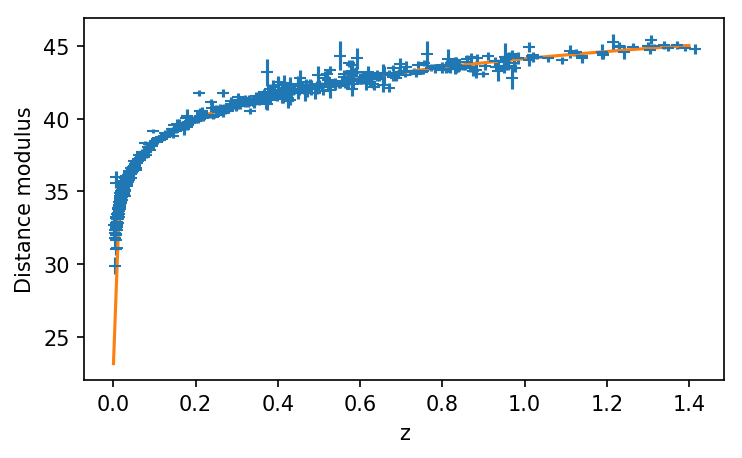

In [6]:
plt.errorbar(SNe_df['z'],SNe_df['d_mod'],yerr=SNe_df['err_d_mod'],fmt='_')
plt.plot(z_grid,dist_mod(z_grid,Hz_flatLCDM,res[0]))
plt.xlabel('z'); plt.ylabel('Distance modulus')

In [7]:
'''
# fith with chi square minimization
def chi2(zdata,dmoddata,dmod_err,Hz_fun,args):
    square = (dmoddata-dist_mod(zdata,Hz_fun,args))**2
    return sum(square/dmod_err**2)

fit_chi2 = lambda cosmo: chi2(SNe_df[mask]['z'],SNe_df[mask]['d_mod'],SNe_df[mask]['err_d_mod'],Hz_flatLCDM,cosmo)
print fit_chi2(cosmo_params)
res = opt.minimize(fit_chi2,
                   x0=cosmo_params)
print res
'''

"\n# fith with chi square minimization\ndef chi2(zdata,dmoddata,dmod_err,Hz_fun,args):\n    square = (dmoddata-dist_mod(zdata,Hz_fun,args))**2\n    return sum(square/dmod_err**2)\n\nfit_chi2 = lambda cosmo: chi2(SNe_df[mask]['z'],SNe_df[mask]['d_mod'],SNe_df[mask]['err_d_mod'],Hz_flatLCDM,cosmo)\nprint fit_chi2(cosmo_params)\nres = opt.minimize(fit_chi2,\n                   x0=cosmo_params)\nprint res\n"

### Calculate Deceleration parameter $q$

In [8]:
# using equation 3.48 of the cosmology notes
q0 = Om/2-Ode
print 'The deceleration parameter is {}, thus, the expansion of the universe is accelerated'.format(q0)

The deceleration parameter is -0.560864045501, thus, the expansion of the universe is accelerated


### Calculate $H_0$
Filter the SNe sample to get the low redshift subset, and make a linear fit to it. The slope will be an aproximation of $H_0$

In [9]:
z_cut = 0.03
H0_mask = (SNe_df['z']<z_cut) & mask

v_SNe = const.c/1000.*SNe_df[H0_mask]['z']

dL_SNe = 10**((SNe_df[H0_mask]['d_mod']-25+2.5*np.log10(1+SNe_df[H0_mask]['z']))/5)
dL_max = 120

v_SNe=v_SNe[dL_SNe<dL_max]
dL_SNe=dL_SNe[dL_SNe<dL_max]
H0_fit, intercept, r, p, err = stat.linregress(dL_SNe,v_SNe)
H0_curvefit = opt.curve_fit(lambda d,H: H*d, dL_SNe, v_SNe, p0=H0)[0][0]

In [18]:
age_fit = 1/H0_fit*1e6*3.86e13/3.154e7/1e9
age_curvefit = 1/H0_curvefit*1e6*3.86e13/3.154e7/1e9
print 'The value of H0 forcing v(z=0)=0 is H0 = {} km/s/Mpc,\nwhich means \
an aproximate age of the universe of {} Myr'.format(H0_curvefit,age_curvefit)
print '\nThe value of H0 NOT forcing v(z=0) is H0 = {0} km/s/Mpc with v(z=0) = {1} km/s,\n\
which means an aproximate age of the universe of {2} Myr'.format(H0_fit,intercept,age_fit)

The value of H0 forcing v(z=0)=0 is H0 = 68.292519309 km/s/Mpc,
which means an aproximate age of the universe of 17.9205973328 Myr

The value of H0 NOT forcing v(z=0) is H0 = 66.4035736649 km/s/Mpc with v(z=0) = 153.499352269 km/s,
which means an aproximate age of the universe of 18.4303746295 Myr


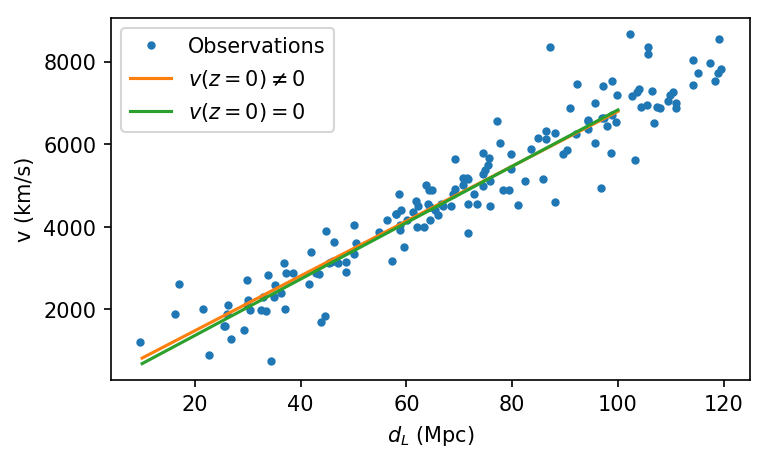

In [11]:
dL_grid = np.linspace(10,100)
plt.plot(dL_SNe,v_SNe,'.',label='Observations')
plt.plot(dL_grid,dL_grid*H0_fit+intercept,label=r'$v(z=0)\neq 0$')
plt.plot(dL_grid,dL_grid*H0_curvefit,label='$v(z=0)= 0$')
plt.xlabel('$d_L$ (Mpc)'); plt.ylabel('v (km/s)')
plt.legend()

### Calculate $w$, the dark matter equation of state parameter

In [12]:
def Hz_w_cte(z,*args):
    H0,Om,Ode,w = args
    Ok = 1-Om-Ode
    Hz = H0*np.sqrt(Om*(1+z)**3+Ok*(1+z)**2+Ode*np.exp(3*(1+w)*np.log(1+z)))
    return Hz

res_w = opt.curve_fit(lambda z,*p: dist_mod(z,Hz_w_cte,p),
                    xdata=SNe_df[mask]['z'],
                    ydata=SNe_df[mask]['d_mod'],
                    sigma = SNe_df[mask]['err_d_mod'], absolute_sigma=True,
                    p0=cosmo_params+[-1])

In [13]:
print 'The fitted parameters are:\n\tH0={1}({5})\n\tOm={2}({6})\
\n\tOk={0}\n\tOde={3}({7})\n\tw={4}({8})'.format(1-sum(res_w[0][1:-1]),*np.append(res_w[0],np.sqrt(np.diag(res_w[1]))))

The fitted parameters are:
	H0=69.6445827527(0.520112610771)
	Om=0.0365399236934(0.482272403182)
	Ok=0.640797280847
	Ode=0.322662795459(0.512920102779)
	w=-1.68827572781(2.16229682722)


Quitar Ok

w necesita mayor redshift

Text(0,0.5,'Distance modulus')

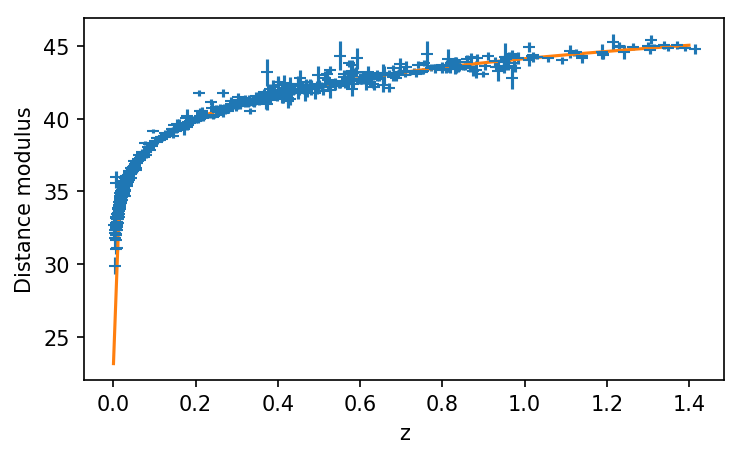

In [14]:
plt.errorbar(SNe_df['z'],SNe_df['d_mod'],yerr=SNe_df['err_d_mod'],fmt='_')
plt.plot(z_grid,dist_mod(z_grid,Hz_w_cte,res_w[0]))
plt.xlabel('z'); plt.ylabel('Distance modulus')

#### Study the effect of Peculiar Velocities

From Davis et al. 2011:

$$
(1+z)=(1+\bar{z})(1-v_\odot/c + v_{SN}/c)
$$

where $z$ is the observed redsfhit, and $\bar{z}$ is the cosmological redshift. 

Reference values: $v_\odot$ = 371km/s, $\sigma_{SN}$ = 300km/s).

The fitted parameters *WITH* peculiar velocities are:
	H0=76.3961164777(0.41774724591)
	Om=1.5198447178(0.198283401128)
	Ok=-2.61434037854
	Ode=2.09449566075(0.17116413042)
The fitted parameters *WITHOUT* considering peculiar velocities are:
	H0=69.5339599448(0.38431218433)
	Om=0.28853943124(0.195593441238)
	Ok=0.00632680763971
	Ode=0.705133761121(0.178658693455)


Text(0,0.5,'Distance Modulus $\\mu$')

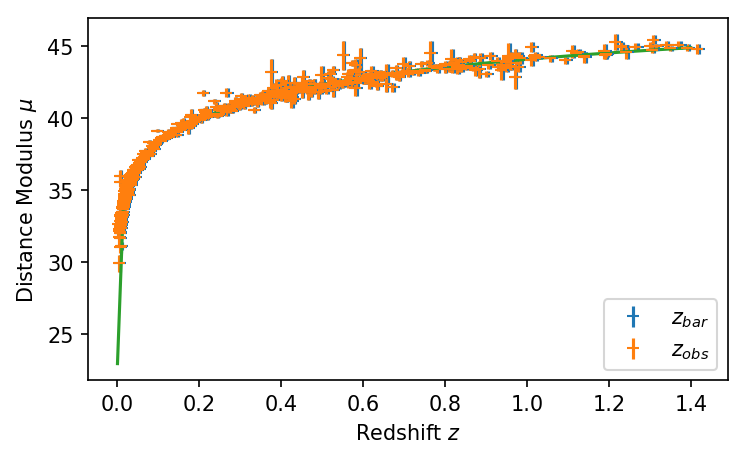

In [15]:
vsun = 371.
vsn = 300.

mask = np.isfinite(SNe_df['z']) & np.isfinite(SNe_df['d_mod'])
z_obs = SNe_df[mask]['z']
N = len(z_obs)
v_SN = np.random.normal(loc=0,scale=300,size=N)
# Note: the redhifts should already be corrected to vsun, therefore, correcting it again makes no sense.
z_bar = (1+z_obs)/(1-(vsun+vsn)*1000/const.c)-1

d_mod = SNe_df[mask]['d_mod']
d_mod_err = SNe_df[mask]['err_d_mod']

cosmo_params = [73.8,.3,0.7]
res_pec = opt.curve_fit(lambda z,*p: dist_mod(z,Hz_flatLCDM,p),
                    xdata=z_bar,
                    ydata=d_mod,
                    sigma = d_mod_err, absolute_sigma=True,
                    p0=cosmo_params)

res_err_pec = np.sqrt(np.diag(res_pec[1]))
H0,Om,Ode = res_pec[0]

print 'The fitted parameters *WITH* peculiar velocities are:\n\tH0={1}({4})\n\tOm={2}({5})\
\n\tOk={0}\n\tOde={3}({6})'.format(1-sum(res_pec[0][1:]),*np.append(res_pec[0],res_err_pec))

print 'The fitted parameters *WITHOUT* considering peculiar velocities are:\n\tH0={1}({4})\n\tOm={2}({5})\
\n\tOk={0}\n\tOde={3}({6})'.format(1-sum(res[0][1:]),*np.append(res[0],res_err))


plt.errorbar(z_bar,d_mod,yerr=d_mod_err,fmt='_', label = r'$z_{bar}$')
plt.errorbar(z_obs,d_mod,yerr=d_mod_err,fmt='_', label = r'$z_{obs}$')
plt.plot(z_grid,dist_mod(z_grid,Hz_flatLCDM,res_pec[0]))
plt.legend(); plt.xlabel('Redshift $z$'); plt.ylabel(r'Distance Modulus $\mu$')


## Questions

* How to fit? Is curve_fit enough?
* Do we have to explore models different than flat Universe?
* In the study of peculiar velocities, we're assuming that the distance modulus remains unchanged after incorporating vsn and Vsun. however, the distance modulus depends on the luminosity distance, which according to Davis et al. (2011), should also be corrected for peculiar velocities. The results presented in this notebook assume $\mu$ is unchanged.


Last question: It's possible to do it theoretically as an order of magnitude.